In [1]:
import pandas as pd
base = pd.read_csv('../databases/petr4.csv')
base = base.dropna()

base = base.iloc[:,1].values
base

array([19.99    , 19.809999, 20.33    , ..., 18.26    , 18.4     ,
       18.42    ])

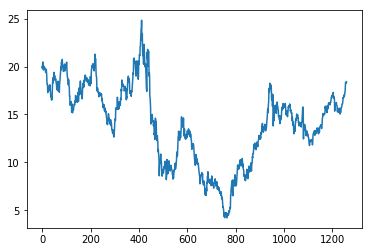

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(base)

In [3]:
periodos = 30
previsao_futura = 1 # horizonte

X = base[0:(len(base) - (len(base) % periodos))]
X_batches = X.reshape(-1, periodos, 1)

y = base[1:(len(base) - (len(base) % periodos)) + previsao_futura]
y_batches = y.reshape(-1, periodos, 1)

X_teste = base[-(periodos + previsao_futura):]
X_teste = X_teste[:periodos]
X_teste = X_teste.reshape(-1, periodos, 1)
y_teste = base[-(periodos):]
y_teste = y_teste.reshape(-1, periodos, 1)

In [4]:
import tensorflow as tf
tf.reset_default_graph()

entradas = 1
neuronios_oculta = 100
neuronios_saida = 1

xph = tf.placeholder(tf.float32, [None, periodos, entradas])
yph = tf.placeholder(tf.float32, [None, periodos, neuronios_saida])

def cria_uma_celula():
    return tf.contrib.rnn.LSTMCell(num_units = neuronios_oculta, activation = tf.nn.relu)

def cria_varias_celulas(dropout=False, layers=4):
    if dropout:
        celulas = tf.nn.rnn_cell.MultiRNNCell([cria_uma_celula() for i in range(layers)])
        return tf.contrib.rnn.DropoutWrapper(celulas, output_keep_prob = 0.1)
    else:
        return tf.nn.rnn_cell.MultiRNNCell([cria_uma_celula() for i in range(layers)])

In [5]:
# Basic Way
celula = tf.contrib.rnn.BasicRNNCell(num_units = neuronios_oculta, activation = tf.nn.relu)
# Connection between the RNN layer with the output layer
celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size = 1)

# # Complex Way
# celula = cria_varias_celulas()
# # Connection between the RNN layer with the output layer
# celula = tf.contrib.rnn.OutputProjectionWrapper(celula, output_size = 1)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [6]:
saida_rnn, _ = tf.nn.dynamic_rnn(celula, xph, dtype = tf.float32)
erro = tf.losses.mean_squared_error(labels = yph, predictions = saida_rnn)
otimizador = tf.train.AdamOptimizer(learning_rate = 0.001)
treinamento = otimizador.minimize(erro)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoca in range(1000):
        _, custo = sess.run([treinamento, erro], feed_dict = {xph: X_batches, yph: y_batches})
        if epoca % 100 == 0:
            print(epoca + 1, ' erro: ', custo)
    
    previsoes = sess.run(saida_rnn, feed_dict = {xph: X_teste})
    print("Done...")

1  erro:  218.32787
101  erro:  3.393272
201  erro:  1.0283978
301  erro:  0.24478604
401  erro:  0.20012954
501  erro:  0.19768623
601  erro:  0.19623375
701  erro:  0.19525044
801  erro:  0.19446626
901  erro:  0.1936947
Done...


In [8]:
import numpy as np
y_teste.shape
y_teste2 = np.ravel(y_teste)

previsoes2 = np.ravel(previsoes)

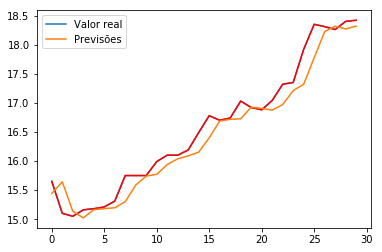

In [9]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste2, previsoes2)

# plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
# plt.plot(previsoes2, 'o', label = 'Previsões')
# plt.legend()

plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()